In [92]:
import os, cv2
import numpy as np
import zipfile
import random
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

base_dir = r'c:\Users\HP\Documents\code_ws\vision_ws\DAGM2007'
os.chdir(base_dir)

In [93]:
os.getcwd()

'c:\\Users\\HP\\Documents\\code_ws\\vision_ws\\DAGM2007'

In [158]:
# ------------------------- 전처리 클래스 -------------------------
class CV2Preprocessor:
    def __init__(self, img):
        if img is None:
            raise ValueError("이미지가 None입니다.")
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img.dtype != 'uint8':
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        self.img = img

    def original_img(self):
        return ("origin", self.img)
    
    def equalize_hist(self):
        eq = cv2.equalizeHist(self.img)
        return ("equ_hist", eq)
    
    def gaussian_blur(self):
        blur = cv2.GaussianBlur(self.img, (5, 5), 0)
        return ("Gaussian", blur)
    
    def canny(self, threshold1=100, threshold2=200):
        canny = cv2.Canny(self.img, threshold1, threshold2)
        return ("Canny", canny)
    
    def dilate(self):
        dilated = cv2.dilate(self.img, np.ones((3, 3), np.uint8), iterations=1)
        return ("Dilate", dilated)
    
    def adaptive_thresh(self):
        adaptive = cv2.adaptiveThreshold(self.img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)
        return ("AdaptiveThreshold", adaptive)
    
    def laplacian(self):
        laplacian = cv2.Laplacian(self.img, cv2.CV_64F)
        laplacian = cv2.convertScaleAbs(laplacian)
        return ("Laplacian", laplacian)
    
    def filters(self, equalize_hist=False, gaussian_blur=False, canny=False, dilate=False, adaptive_thresh=False, laplacian=False):
        selected= [equalize_hist, gaussian_blur, canny, dilate, adaptive_thresh, laplacian]
        filter_lists= [self.equalize_hist(), self.gaussian_blur(), self.canny(), self.dilate(), self.adaptive_thresh(), self.laplacian()]
        selected_filters= []

        for sel, fil in zip(selected, filter_lists):
            if sel:
                selected_filters.append(fil)
        
        selected_filters= selected_filters if selected_filters else [self.original_img()]
        title= ''
        origin_img = self.img
        for fil in selected_filters:
            name, preprocessed_img = fil
            title= name if title=='' else title + ' + ' + name
            self.img= preprocessed_img

        result_img= self.img
        self.img= origin_img

        return title, result_img
    
    ###########################################################################################

    def hist_blur(self):
        eq = cv2.equalizeHist(self.img)
        blur = cv2.GaussianBlur(eq, (5, 5), 0)
        return ("equ_hist + Gaussian", blur)

    def hist_blur_canny(self):
        eq = cv2.equalizeHist(self.img)
        blur = cv2.GaussianBlur(eq, (5, 5), 0)
        canny = cv2.Canny(blur, 100, 200)
        return ("equ_hist + Gaussian + Canny", canny)

    def hist_blur_canny_dilate(self):
        eq = cv2.equalizeHist(self.img)
        blur = cv2.GaussianBlur(eq, (5, 5), 0)
        canny = cv2.Canny(blur, 100, 200)
        dilated = cv2.dilate(canny, np.ones((3, 3), np.uint8), iterations=1)
        return ("equ_hist + Gaussian + Canny + Dilate", dilated)

    def hist_blur_adaptive_thresh(self):
        eq = cv2.equalizeHist(self.img)
        blur = cv2.GaussianBlur(eq, (5, 5), 0)
        adaptive = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)
        return ("equ_hist + Gaussian + AdaptiveThreshold", adaptive)

    def hist_blur_laplacian(self):
        eq = cv2.equalizeHist(self.img)
        blur = cv2.GaussianBlur(eq, (5, 5), 0)
        laplacian = cv2.Laplacian(blur, cv2.CV_64F)
        laplacian = cv2.convertScaleAbs(laplacian)
        return ("equ_hist + Gaussian + Laplacian", laplacian)

    def all_methods(self):
        return [
            self.original_img(),
            self.hist_blur(),
            self.hist_blur_canny(),
            self.hist_blur_canny_dilate(),
            self.hist_blur_adaptive_thresh(),
            self.hist_blur_laplacian()
        ]

In [130]:
# ------------------------- 이미지 로딩 및 샘플링 클래스 -------------------------
class ImageShow:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.selected_images = []

    def random_sample_imgs(self, n: int, show_plot: bool = True, extension: str = '*.png'):
        os.chdir(os.path.join(base_dir, self.folder_path))
        files = glob(extension)
        if not files:
            raise FileNotFoundError("해당 확장자의 이미지가 존재하지 않습니다.")
        self.selected_images = random.sample(files, min(n, len(files)))

        if show_plot:
            plt.figure(figsize=(8, 6))
            for idx, path in enumerate(self.selected_images, 1):
                img = cv2.imread(path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(1, n, idx)
                plt.imshow(img_rgb)
                plt.title(os.path.basename(path))
                plt.axis('off')
            plt.tight_layout()
            plt.show()

In [127]:
# ------------------------- 시각화 함수 -------------------------
def plot_preprocessing_results(results, figsize=(15, 3), cmap='gray'):
    plt.figure(figsize=figsize)
    for i, (title, image) in enumerate(results, 1):
        plt.subplot(1, len(results), i)
        plt.imshow(image, cmap=cmap)
        plt.title(title, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [96]:
os.chdir(base_dir)
# 사용자 설정
n = 4  # 표시할 이미지 수
image_extension = '*.png'
zip_extension = '*.zip'

# 1. 현재 경로에서 png 파일이 있는지 확인
png_files = glob(image_extension)
zip_dirs = glob(zip_extension)

if not zip_dirs:
    print("❌ PNG 파일도, 압축 파일도 존재하지 않습니다.")

for zip_dir in zip_dirs:
    dir_name = str(zip_dir).split('.')[0]
    if os.path.isdir(str(dir_name)): 
        continue

    print(f"📦 압축 해제 시작: {zip_dir}")
    with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
        zip_ref.extractall(".")
    os.chdir(f'.\\{str(dir_name)}')
    png_files = glob(image_extension)
    if not png_files:
        print("⚠️ 압축을 풀었지만 PNG 파일이 없습니다.")
    else:
        print(f"✅ {len(png_files)}개의 PNG 파일이 추출되었습니다.")
    
    os.chdir(base_dir)

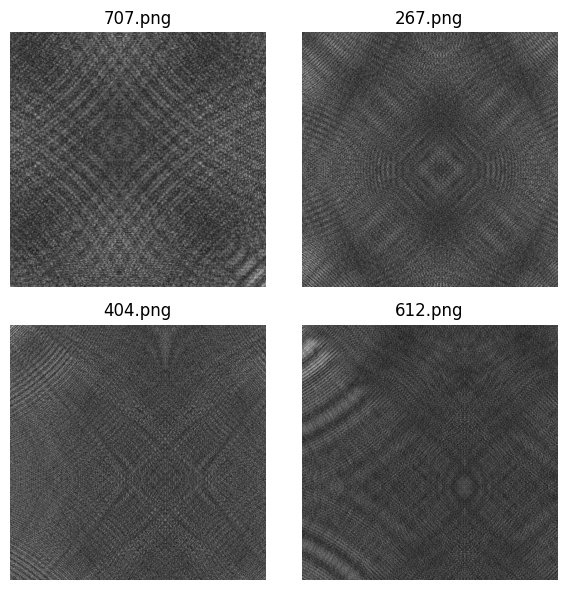

In [108]:
os.chdir(os.path.join(base_dir, 'Class1'))
png_files = glob(image_extension)
# 2. 랜덤으로 n개의 이미지를 선택하고 보여줌
sample_imgs = []
if png_files:
    selected_images = random.sample(png_files, min(n, len(png_files)))

    plt.figure(figsize=(6, 6))
    for idx, img_path in enumerate(selected_images, 1):
        # img = Image.open(img_path)
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        
        sample_imgs.append(img)

        plt.subplot(2, 2, idx)
        # plt.imshow(img, cmap='gray')
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

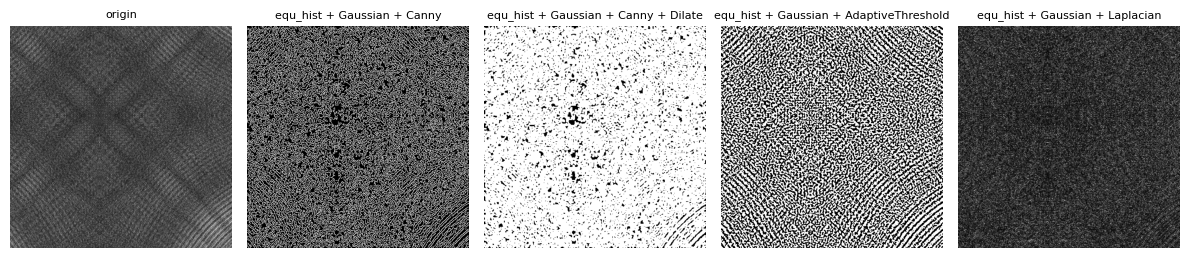

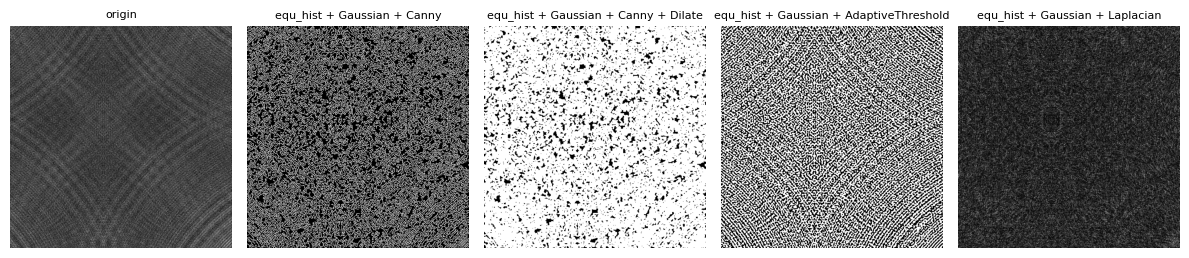

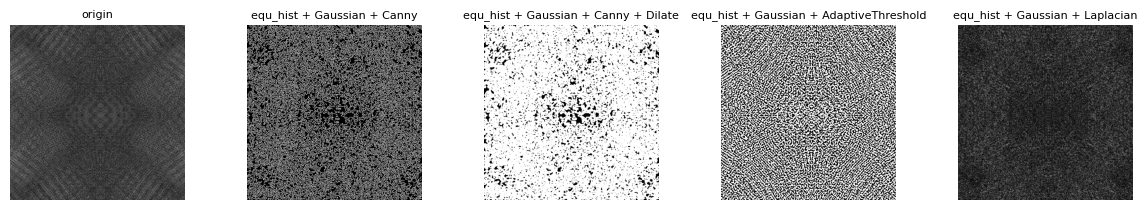

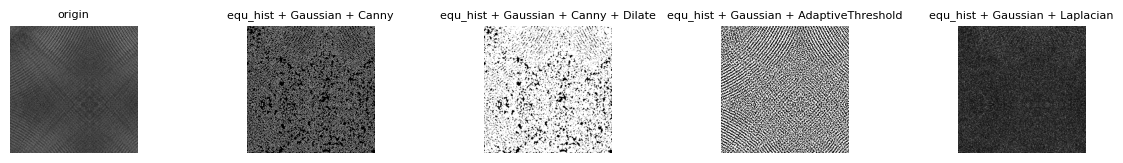

In [98]:
for idx, img in enumerate(sample_imgs,1):
    processor = CV2Preprocessor(img)

    methods = [
        processor.orignal_img,
        processor.hist_blur_canny,
        processor.hist_blur_canny_dilate,
        processor.hist_blur_adaptive_thresh,
        processor.hist_blur_laplacian,
    ]

    plt.figure(figsize=(12, 6))
    for i, method in enumerate(methods, 1):
        title, result = method()
        plt.subplot(idx, len(methods), i)
        plt.imshow(result, cmap='gray')
        plt.title(title, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

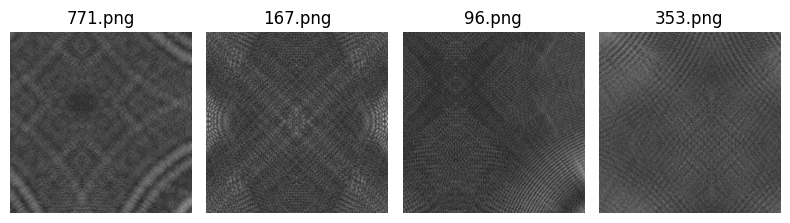

In [131]:
img_show = ImageShow('Class1')  # 폴더 이름 지정
img_show.random_sample_imgs(n=4, show_plot=True)

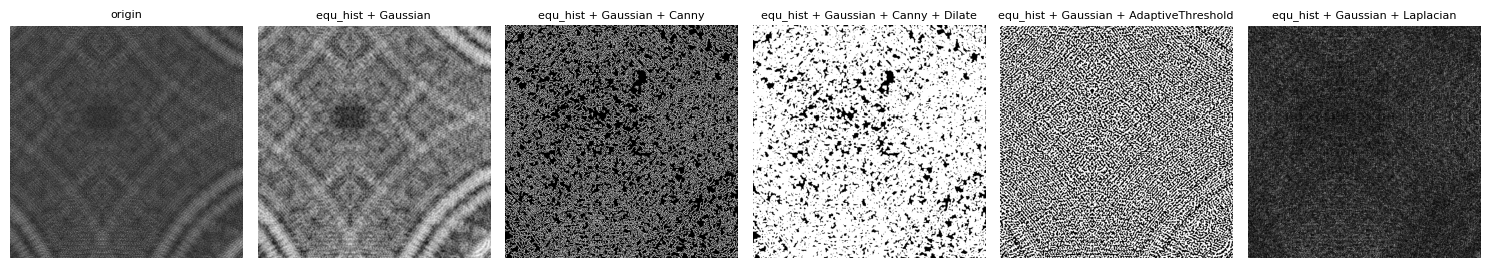

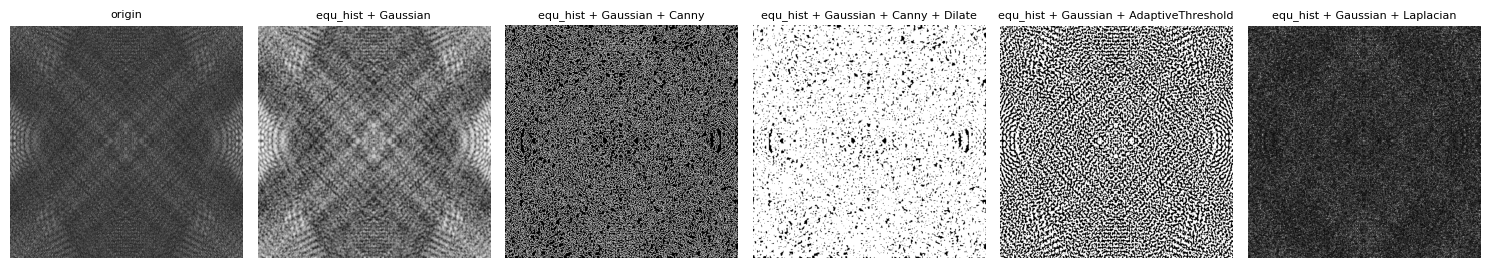

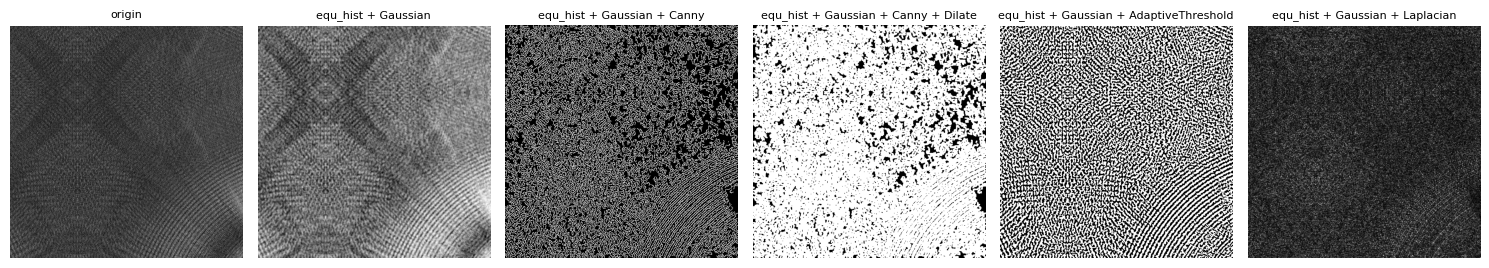

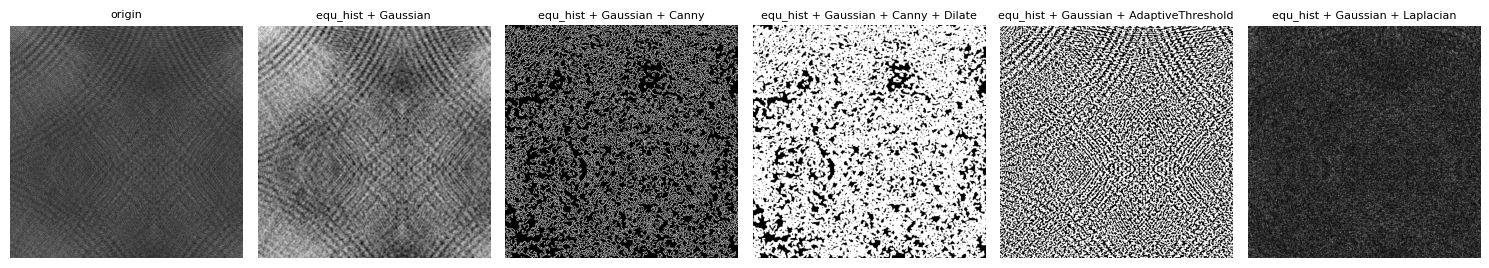

In [132]:
for path in img_show.selected_images:
    img = cv2.imread(path)
    processor = CV2Preprocessor(img)
    results = processor.all_methods()
    plot_preprocessing_results(results)

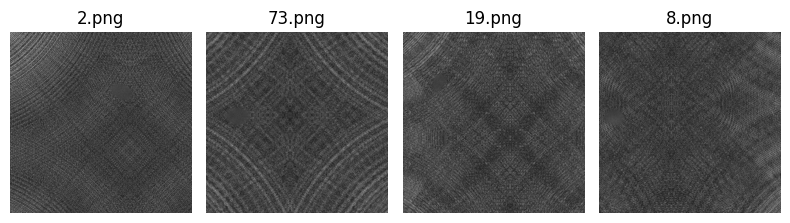

In [136]:
img_show = ImageShow('Class1_def')  # 폴더 이름 지정
img_show.random_sample_imgs(n=4, show_plot=True)

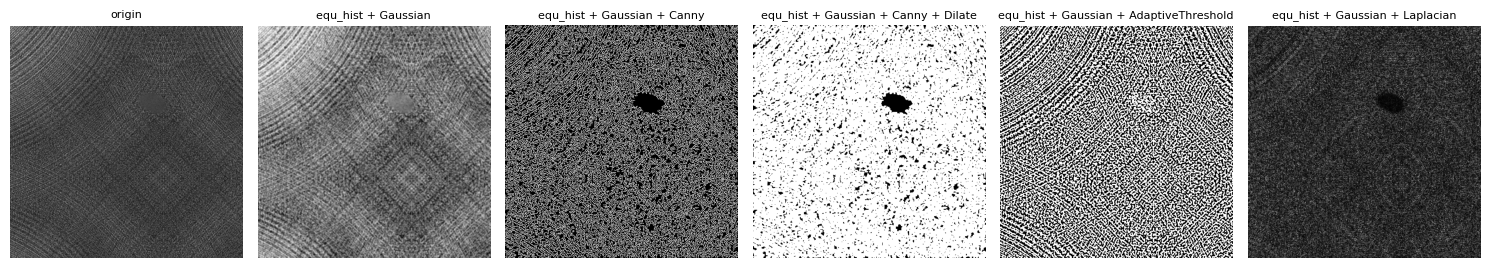

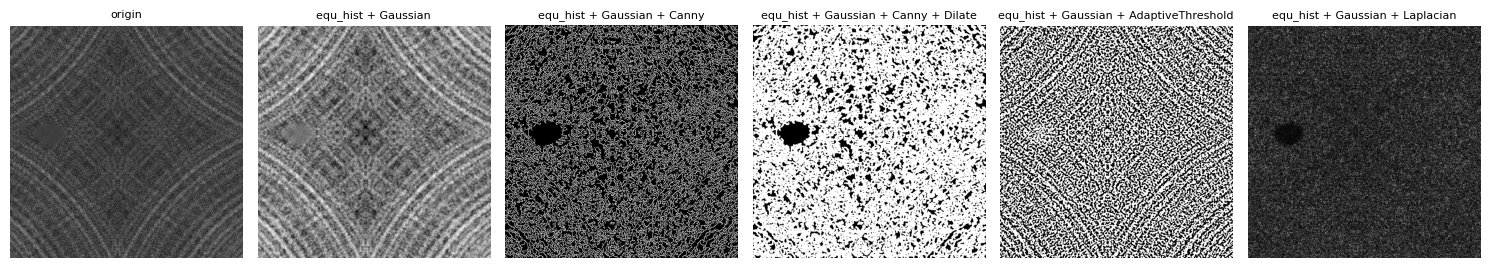

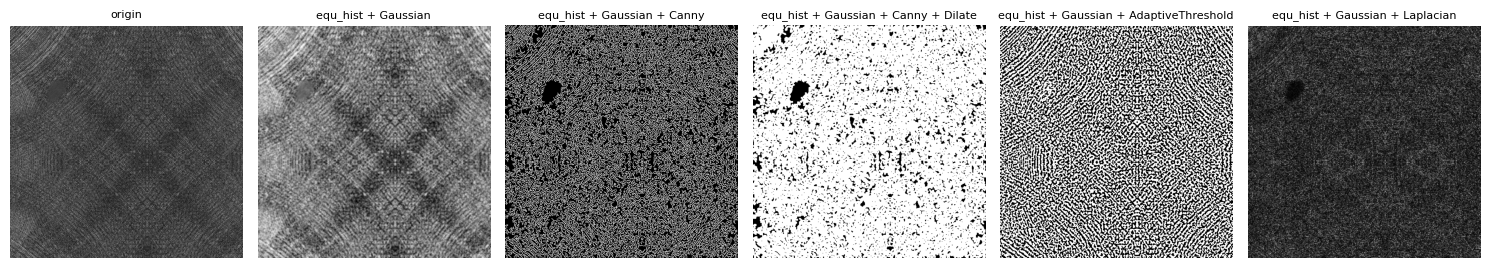

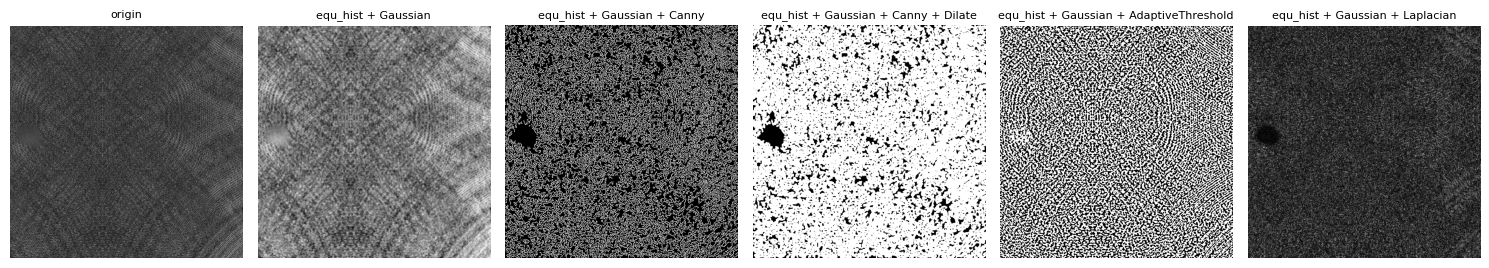

In [137]:
for path in img_show.selected_images:
    img = cv2.imread(path)
    processor = CV2Preprocessor(img)
    results = processor.all_methods()
    plot_preprocessing_results(results)

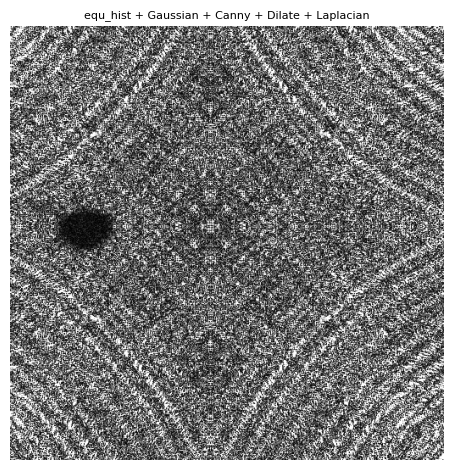

In [ ]:
img_show = ImageShow('Class1_def')  # 폴더 이름 지정
img_show.random_sample_imgs(n=1, show_plot=False)

img = img_show.selected_images[0]
img = os.path.join(base_dir,'Class1_def/73.png')
img = cv2.imread(img)
processor = CV2Preprocessor(img)
# title, image = processor.filters(equalize_hist=True, gaussian_blur=True, canny=True, dilate=True)
title, image = processor.filters(equalize_hist=True, gaussian_blur=True, canny=True, dilate=True, laplacian=True)

plt.imshow(image, cmap='gray')
plt.title(title, fontsize=8)
plt.axis('off')
plt.tight_layout()
plt.show()